In [ ]:
###perovskite screening###

In [2]:
#%matplotlib notebook
import ase.db
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
#from tabulate import tabulate
import seaborn as sns
import scipy as sp

In [2]:
dbase = ase.db.connect('cubic_perovskites.db')
# Do not include the so-called "reference systems"
syss=[c for c in dbase.select() if not hasattr(c,"reference")]

In [3]:
syss[0]._keys

['project',
 'A_ion',
 'anion',
 'combination',
 'CB_ind',
 'gllbsc_ind_gap',
 'heat_of_formation_all',
 'CB_dir',
 'gllbsc_dir_gap',
 'standard_energy',
 'B_ion',
 'VB_dir',
 'VB_ind']

In [4]:
Aset=set()
Bset=set()
anionset=set()
for p in syss:
    Aset.add(p.A_ion)
    Bset.add(p.B_ion)
    anionset.add(p.anion)
Alist=list(Aset)
Alist.sort()
Blist=list(Bset)
Blist.sort()
anionlist=list(anionset)
anionlist.sort()

In [5]:
# Anions: O,N,S,F
aniondict={'N3':[0,3,0,0],'O2F':[2,0,0,1], 'O2N':[2,1,0,0], 'O2S':[2,0,1,0],'O3':[3,0,0,0], 'OFN':[1,1,0,1],'ON2':[1,2,0,0]}

In [6]:
elemdict={'Ag':[5,11],
          'Al':[3,13],
          'As':[4,15],
          'Au':[6,11],
          'B':[2,13],
          'Ba':[6,2],
          'Be':[2,2],
          'Bi':[6,15],
          'Ca':[4,2],
          'Cd':[5,12],
          'Co':[4,9],
          'Cr':[4,6],
          'Cs':[6,1],
          'Cu':[4,11],
          'Fe':[4,8],
          'Ga':[4,13],
          'Ge':[4,14],
          'Hf':[6,4],
          'Hg':[6,12],
          'In':[5,13],
          'Ir':[6,9],
          'K':[4,1],
          'La':[6,2.5],
          'Li':[2,1],
          'Mg':[3,2],
          'Mn':[4,7],
          'Mo':[5,6],
          'Na':[3,1],
          'Nb':[5,5],
          'Ni':[4,10],
          'Os':[6,8],
          'Pb':[6,14],
          'Pd':[5,10],
          'Pt':[6,10],
          'Rb':[5,1],
          'Re':[6,7],
          'Rh':[5,9],
          'Ru':[5,8],
          'Sb':[5,15],
          'Sc':[4,3],
          'Si':[3,14],
          'Sn':[5,14],
          'Sr':[5,2],
          'Ta':[6,5],
          'Te':[5,16],
          'Ti':[4,4],
          'Tl':[6,13],
          'V':[4,5],
          'W':[6,6],
          'Y':[5,3],
          'Zn':[4,12],
          'Zr':[5,4]}

In [7]:
energies = [s.heat_of_formation_all for s in syss]

<IPython.core.display.Javascript object>


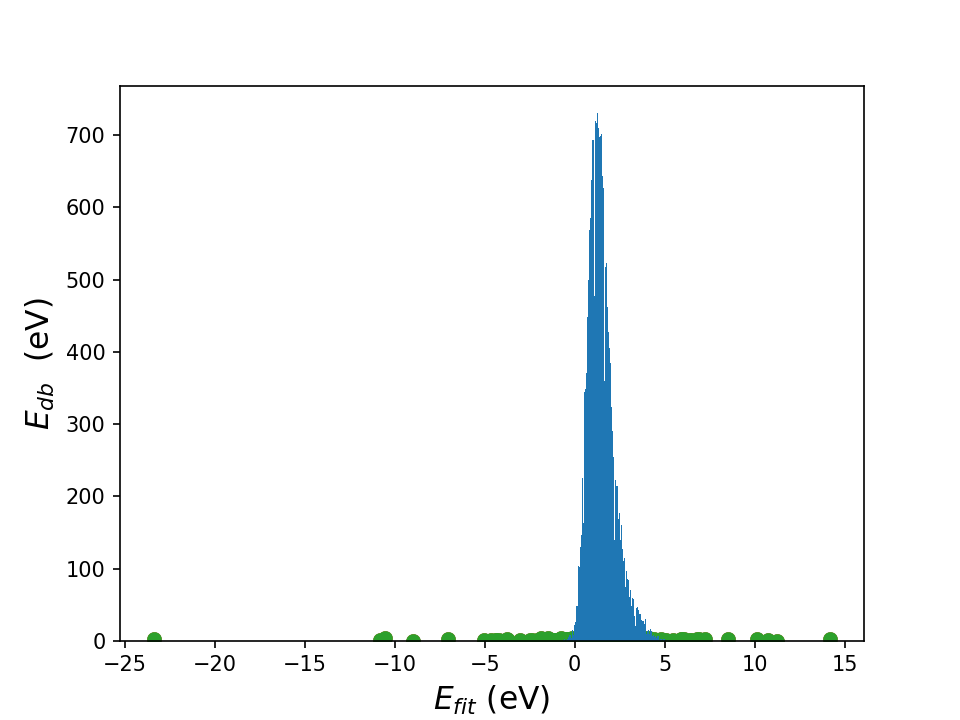

In [8]:
hist=plt.hist(energies,bins=100)

In [14]:
#set up the kernel

In [9]:
def finger(s):
    return np.concatenate([elemdict[s.A_ion],elemdict[s.B_ion],np.asarray(aniondict[s.anion])])

In [10]:
s=syss[3]
a = finger(s)
print(a)

[ 6 15  5 15  2  1  0  0]


In [11]:
###testing###
trainset_test = np.random.choice(syss, 2, replace=False)
train_fp_test = np.array([finger(ts) for ts in trainset_test])
thfe_test = np.array([s.heat_of_formation_all for s in trainset_test])
print(trainset_test,train_fp_test, thfe_test)

 <ase.db.row.AtomsRow object at 0x000001B4F4FD07C8>] [[ 6.   8.   2.   1.   1.   1.   0.   1. ]
 [ 6.   2.5  5.  10.   1.   2.   0.   0. ]] [2.44 1.18]


In [13]:
print(len(syss))

18928


In [14]:
#set the training/test sets
new_sys = np.random.permutation(syss)
trainset = new_sys[:500]
testset = new_sys[500:700]
x_train = np.array([finger(ts) for ts in trainset])  #x_train
x_test = np.array([finger(ts) for ts in testset]) # x_test
y_train = np.array([s.heat_of_formation_all for s in trainset]) #y_train
y_test = np.array([s.heat_of_formation_all for s in testset]) #y_est

In [6]:
np.arange(6).reshape((-1, 1))

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])

In [45]:

class GP:
    "Class used for training and predicting using Gaussian process"
    def __init__ (self, l, k0, sigma): 
        self.l = l
        self.k0 = k0
        self.sigma = sigma
       
    def calc_K(self, x_data1, x_data2):
        #x_data1 = x_data1.reshape(len(x_dat),1)
        #x_data2 = x_data2.reshape(-1,1)
        dist = np.sum(x_data1**2,axis=1).reshape(-1,1)+np.sum(x_data2**2,axis=1)-2*np.dot(x_data1, x_data2.T)
        K = self.k0*np.exp(-0.5*(dist)/(self.l)**2)
        #K =  np.array([[self.kernel(x,xx) for x in xp] for xx in xp])
        return K
    
    def calc_C(self, x_train):
        "Calculates C matrix. xp is sample x-values"
        K = self.calc_K(x_train,x_train)
        C = K + self.sigma**2*np.identity(len(K))
        return C
    
    def train(self, x_train, y_train):
        "xp is x-values of samples, tp is y-values of samples. Returns C invers and C invers dotted with t"
        C = self.calc_C(x_train)
        Cinv = np.linalg.inv(C)
        coef = np.matmul(Cinv, y_train.reshape(-1,1)) #didnt take yp into account
        return coef
   
    def predict(self, x_test,x_train, y_train):
        "xp is x-values of sample points, tp is y-values of sample points, grid is the grid to be fitted to"
        coef = self.train(x_train, y_train)
        k_mat_test = self.calc_K(x_test, x_train)
        return np.matmul(k_mat_test, coef)
       

In [46]:
#basic parameters
l = 5
k0 = 1
sigma = 0.002
model = GP(l,k0,sigma)


In [47]:
predictions = model.predict(x_test,x_train, y_train)

In [48]:
predictions

array([[ 1.6559912 ],
       [ 1.01953206],
       [ 0.73853805],
       [-0.33050086],
       [ 0.8911967 ],
       [ 0.52502441],
       [ 2.07423182],
       [ 2.12705997],
       [ 4.47907658],
       [ 1.01153735],
       [ 1.17951982],
       [ 2.00255498],
       [ 1.90903631],
       [ 1.97470919],
       [-0.46635215],
       [ 2.73106489],
       [ 3.38403105],
       [ 0.70304816],
       [ 1.29496754],
       [ 0.50859748],
       [ 2.41622921],
       [ 2.94756765],
       [ 1.48588537],
       [ 1.29166289],
       [ 1.90617984],
       [ 2.0826653 ],
       [ 1.02439625],
       [ 1.40118269],
       [ 0.42289697],
       [ 1.00260167],
       [ 0.54273262],
       [ 0.32289405],
       [ 0.88134039],
       [ 0.78147836],
       [ 0.80956402],
       [ 0.96135132],
       [ 2.07639809],
       [ 2.40684124],
       [ 1.40546999],
       [ 1.08088791],
       [ 5.70367272],
       [ 0.30680821],
       [ 0.53271873],
       [ 0.65575398],
       [ 1.43566441],
       [ 0

(200, 1)

<IPython.core.display.Javascript object>


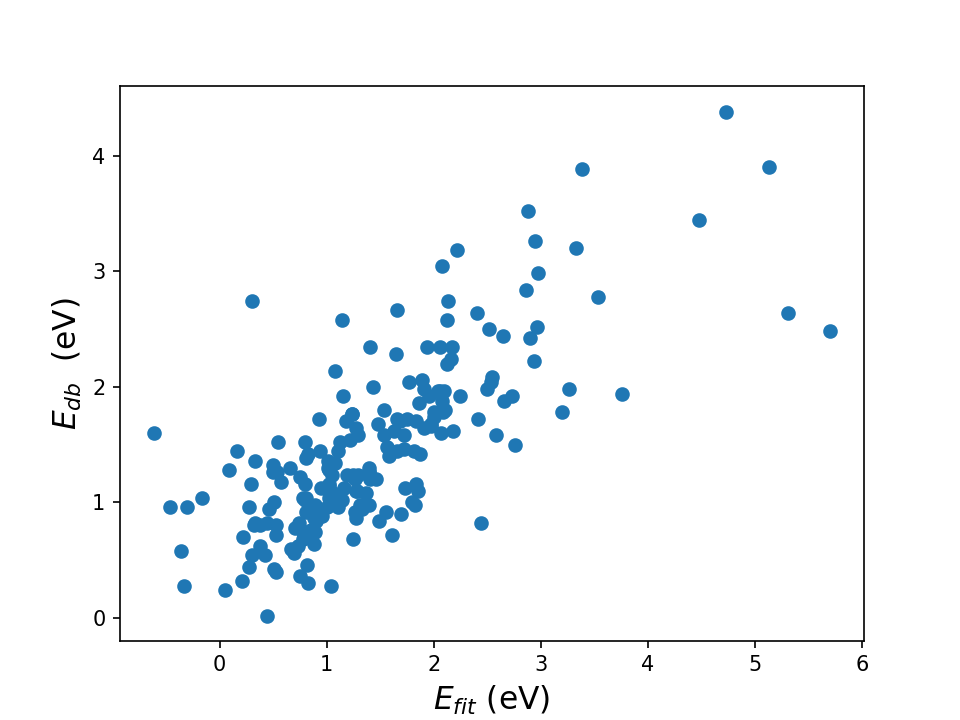

Text(0, 0.5, '$E_{db}$  (eV)')

In [49]:
plt.scatter(predictions, y_test)
plt.xlabel('$E_{fit}$ (eV)',fontsize=15)
plt.ylabel('$E_{db}$  (eV)',fontsize=15)
#plt.show()